# Bitcoin Price Analysis: 2012-2020
## A Comprehensive Study of Cryptocurrency Market Dynamics

**Author:** Egi Gjineci  
**Date:** November 2025  
**Dataset:** Bitstamp USD 1-minute data  
**Duration:** 2012-01-01 to 2020-04-22

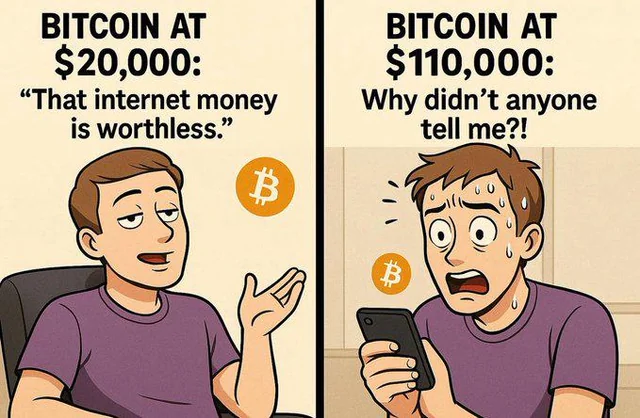

### 📊 Executive Summary

This notebook analyzes 8+ years of Bitcoin trading data from Bitstamp exchange, examining price movements, trading patterns, volatility, and global trading dynamics. The analysis reveals critical insights into cryptocurrency market behavior, including seasonal trends, intraday patterns, and geographic trading patterns.

**Key Findings:**
- Bitcoin experienced exponential growth with a peak of ~$20K in 2017
- Trading volume concentrates during European and American business hours
- 28.35% of data contained missing values; intelligent imputation preserved data relationships
- High volatility periods correspond with major price movements

## Setup & Libraries

We begin by importing necessary libraries for data manipulation, analysis, and visualization. Each library serves a specific purpose in our analysis pipeline.

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Data Loading & Exploration

The Bitstamp dataset contains minute-level trading data including:
- **Open/High/Low/Close (OHLC):** Price information
- **Volume:** Trading activity in BTC and currency
- **Weighted Price:** Volume-weighted average price

Let's load and examine the raw data structure.

In [26]:
df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv')
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
print("="*80)
print("BITCOIN PRICE ANALYSIS - BITSTAMP USD")
print("="*80)

# Basic info
print("\nDataset Info:")
df.info()
print("-"*80)

# Missing values
print("\nMissing Values:")
missing = pd.DataFrame({
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
print(missing)
print("-"*80)

# Basic statistics
print("\nBasic Statistics:")
print(df.describe())

BITCOIN PRICE ANALYSIS - BITSTAMP USD

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4363457 entries, 0 to 4363456
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 266.3 MB
--------------------------------------------------------------------------------

Missing Values:
                   Missing_Count  Missing_Percentage
Timestamp                      0                0.00
Open                     1236977               28.35
High                     1236977               28.35
Low                      1236977               28.35
Close                    1236977               28.35
Volume_(BTC)             1236977               

## Data Cleaning & Processing

### Imputation Strategy

Rather than simply removing ~28% of data, we employ a **context-aware imputation strategy**:

1. **For Volume:** If price is stable → forward/backward fill; if price changed → interpolate
2. **For Price:** If volume is stable → forward/backward fill; if volume changed → interpolate
3. **Rationale:** No volume change + no price change = market idle; use last known value

This preserves market dynamics while maintaining data integrity.

In [29]:
print("\n" + "="*80)
print("3. DATA PROCESSING")
print("="*80)

# Create a copy
df_clean = df.copy()

# Convert timestamp to datetime
df_clean['Timestamp'] = pd.to_datetime(df_clean['Timestamp'], unit='s')
print("\n✓ Converted Timestamp to datetime")

# Rename columns for clarity
df_clean.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume_btc', 'volume_currency', 'weighted_price']
print("✓ Renamed columns to lowercase with underscores")

# Check missing values
print(f"\nMissing values before cleaning\n: {df_clean.isnull().sum()}")

# Check if entire rows are NaN
rows_all_nan = df_clean[df_clean.isnull().all(axis=1)].shape[0]
print(f"Rows with all values missing: {rows_all_nan}")

price_cols = ['open', 'high', 'low', 'close', 'weighted_price']
volume_cols = ['volume_btc', 'volume_currency']

# STEP 1: Handle VOLUME missing values
for vol_col in volume_cols:
    # Check where volume is missing
    vol_missing_mask = df_clean[vol_col].isna()
    vol_missing_count = vol_missing_mask.sum()
    
    if vol_missing_count > 0:
        # Calculate price changes (using 'close' as reference)
        df_clean['price_changed'] = df_clean['close'].diff().fillna(0) != 0
        
        # Case 1: Volume missing + Price UNCHANGED → Forward/Backward fill
        # Logic: No price change likely means no trading, so last volume makes sense
        stable_price_mask = vol_missing_mask & (~df_clean['price_changed'])
        
        # Case 2: Volume missing + Price CHANGED → Interpolate
        # Logic: Price changed, so trading likely happened, interpolate volume
        changed_price_mask = vol_missing_mask & df_clean['price_changed']
        
        #print(f"   {vol_col}:")
        #print(f"     - Missing with stable price: {stable_price_mask.sum()} → Forward/Backward fill")
        #print(f"     - Missing with price change: {changed_price_mask.sum()} → Interpolate")
        
        # Apply Case 1: Forward/Backward fill for stable prices
        df_clean.loc[stable_price_mask, vol_col] = df_clean[vol_col].ffill().bfill()[stable_price_mask]
        
        # Apply Case 2: Interpolate for price changes
        df_clean.loc[changed_price_mask, vol_col] = df_clean[vol_col].interpolate(method='linear')[changed_price_mask]
        
        # Final cleanup: any remaining NaN → fill with 0 (assumed no trading)
        remaining = df_clean[vol_col].isna().sum()
        if remaining > 0:
            df_clean[vol_col] = df_clean[vol_col].fillna(0)
            print(f"     - Remaining NaNs: {remaining} → Filled with 0 (no trading)")


for price_col in price_cols:
    # Check where price is missing
    price_missing_mask = df_clean[price_col].isna()
    price_missing_count = price_missing_mask.sum()
    
    if price_missing_count > 0:
        # Calculate volume changes
        df_clean['volume_changed'] = df_clean['volume_btc'].diff().fillna(0) != 0
        
        # Case 1: Price missing + Volume UNCHANGED → Forward/Backward fill
        # Logic: No volume change likely means market idle, price stays same
        stable_volume_mask = price_missing_mask & (~df_clean['volume_changed'])
        
        # Case 2: Price missing + Volume CHANGED → Interpolate
        # Logic: Volume changed, so market active, interpolate price movement
        changed_volume_mask = price_missing_mask & df_clean['volume_changed']
        
        #print(f"   {price_col}:")
        #print(f"     - Missing with stable volume: {stable_volume_mask.sum()} → Forward/Backward fill")
        #print(f"     - Missing with volume change: {changed_volume_mask.sum()} → Interpolate")
        
        # Apply Case 1: Forward/Backward fill for stable volume
        df_clean.loc[stable_volume_mask, price_col] = df_clean[price_col].ffill().bfill()[stable_volume_mask]
        
        # Apply Case 2: Interpolate for volume changes
        df_clean.loc[changed_volume_mask, price_col] = df_clean[price_col].interpolate(method='linear')[changed_volume_mask]
        
        # Final cleanup: any remaining NaN → forward/backward fill
        remaining = df_clean[price_col].isna().sum()
        if remaining > 0:
            df_clean[price_col] = df_clean[price_col].ffill().bfill()
            print(f"     - Remaining NaNs: {remaining} → Forward/Backward fill")

# Drop temporary helper columns
df_clean = df_clean.drop(['price_changed', 'volume_changed'], axis=1, errors='ignore')

print(f"\nMissing values after intelligent cleaning: {df_clean.isnull().sum().sum()}")
print("✓ Applied context-aware imputation based on price-volume relationships")

# Remove any remaining rows with NaN
df_clean = df_clean.dropna()
print(f"✓ Final dataset shape: {df_clean.shape[0]:,} rows × {df_clean.shape[1]} columns")


3. DATA PROCESSING

✓ Converted Timestamp to datetime
✓ Renamed columns to lowercase with underscores

Missing values before cleaning
: timestamp                0
open               1236977
high               1236977
low                1236977
close              1236977
volume_btc         1236977
volume_currency    1236977
weighted_price     1236977
dtype: int64
Rows with all values missing: 0

Missing values after intelligent cleaning: 0
✓ Applied context-aware imputation based on price-volume relationships
✓ Final dataset shape: 4,363,457 rows × 8 columns


## Feature Engineering

### Creating Analytical Features

Create derived features to support deeper analysis across three categories:

#### Temporal Features
Extract time components from timestamp data for pattern analysis by time periods.

#### Price & Returns Features
Calculate price movements and returns to analyze market dynamics and volatility.

#### Categorical Features
Bin continuous variables into categories for segmented analysis and easier interpretation.

| Feature Type | Feature | Calculation/Purpose |
|---|---|---|
| **Temporal** | `year`, `month`, `day`, `hour`, `day_of_week`, `day_name` | Extract temporal components for seasonal/intraday pattern analysis |
| **Price Movement** | `price_change` | Close - Open (absolute movement in USD) |
| **Price Movement** | `price_change_pct` | ((Close - Open) / Open) × 100 (percentage change) |
| **Returns** | `return_1m` | Minute-level returns (pct_change for time-series analysis) |
| **Volatility** | `volatility` | High - Low (intraday price range in USD) |
| **Volatility** | `volatility_pct` | (High - Low) / Open × 100 (volatility as % of price) |
| **Activity Flag** | `has_trading` | Binary indicator (1 if volume > 0, else 0) |
| **Price Category** | `price_category` | Bins: <$1K, $1K-$5K, $5K-$10K, $10K-$20K, >$20K |
| **Volume Category** | `volume_category` | Quantile-based bins: Low (0-33%), Medium (33-67%), High (67-100%) |

These features enable sophisticated analysis patterns across multiple dimensions.

In [30]:
# Ensure numeric types
numeric_cols = ['open', 'high', 'low', 'close', 'volume_btc', 'volume_currency', 'weighted_price']
df_clean[numeric_cols] = df_clean[numeric_cols].apply(pd.to_numeric, errors='coerce')
print("✓ Ensured all price/volume columns are numeric")

# Extract time features
df_clean['year'] = df_clean['timestamp'].dt.year
df_clean['month'] = df_clean['timestamp'].dt.month
df_clean['day'] = df_clean['timestamp'].dt.day
df_clean['hour'] = df_clean['timestamp'].dt.hour
df_clean['day_of_week'] = df_clean['timestamp'].dt.dayofweek
df_clean['day_name'] = df_clean['timestamp'].dt.day_name()
print("✓ Created time-based features (year, month, day, hour, day_of_week)")

# Price change and percentage change
df_clean['price_change'] = df_clean['close'] - df_clean['open']
df_clean['price_change_pct'] = ((df_clean['close'] - df_clean['open']) / df_clean['open'] * 100)
df_clean["return_1m"] = df["Close"].pct_change(fill_method=None)    # Minute returns
print("✓ Created price change features")

# Volatility (high-low range)
df_clean['volatility'] = df_clean['high'] - df_clean['low']
df_clean['volatility_pct'] = (df_clean['volatility'] / df_clean['open'] * 100)
print("✓ Created volatility features")

# Trading activity flag
df_clean['has_trading'] = (df_clean['volume_btc'] > 0).astype(int)
print("✓ Created trading activity flag")

# Price bins (for categorization)
df_clean['price_category'] = pd.cut(df_clean['close'], 
                                     bins=[0, 1000, 5000, 10000, 20000, float('inf')],
                                     labels=['<$1K', '$1K-$5K', '$5K-$10K', '$10K-$20K', '>$20K'])
print("✓ Created price category bins")

# Volume bins
volume_quantiles = df_clean[df_clean['volume_btc'] > 0]['volume_btc'].quantile([0.33, 0.67])
df_clean['volume_category'] = pd.cut(df_clean['volume_btc'],
                                      bins=[0, volume_quantiles.iloc[0], volume_quantiles.iloc[1], float('inf')],
                                      labels=['Low', 'Medium', 'High'])
print("✓ Created volume category bins")

print(f"\nFinal dataset columns: {df_clean.shape[1]}")
print(df_clean.columns.tolist())

✓ Ensured all price/volume columns are numeric
✓ Created time-based features (year, month, day, hour, day_of_week)
✓ Created price change features
✓ Created volatility features
✓ Created trading activity flag
✓ Created price category bins
✓ Created volume category bins

Final dataset columns: 22
['timestamp', 'open', 'high', 'low', 'close', 'volume_btc', 'volume_currency', 'weighted_price', 'year', 'month', 'day', 'hour', 'day_of_week', 'day_name', 'price_change', 'price_change_pct', 'return_1m', 'volatility', 'volatility_pct', 'has_trading', 'price_category', 'volume_category']


## Summary Statistics

### Overview

Summary statistics provide quantitative insights into Bitcoin's market behavior across different time periods. We analyze annual trends, day-of-week patterns, and intraday activity to identify temporal patterns in price and volume.

### Annual Performance Metrics

The table below summarizes key metrics for each year, revealing trends in price movements, volatility, and trading activity. Each row represents one calendar year.

**Columns Explained:**
- **Avg_Price**: Mean closing price for the year
- **Min_Price / Max_Price**: Annual low and high prices
- **Price_StdDev**: Standard deviation (volatility indicator)
- **Total_Volume_BTC**: Cumulative trading volume in Bitcoin
- **Avg_PriceChange_%**: Average intraday price movement
- **Avg_Volatility_%**: Average intraday volatility as % of price
- **Data_Points**: Number of 1-minute records (data density)

In [31]:
# =============================================================================
# 4. SUMMARY STATISTICS WITH PANDAS
# =============================================================================

print("\n" + "="*80)
print("4. SUMMARY STATISTICS")
print("="*80)

# KEY SUMMARY TABLE: Yearly Bitcoin Statistics
yearly_summary = df_clean.groupby('year').agg({
    'close': ['mean', 'min', 'max', 'std'],
    'volume_btc': 'sum',
    'price_change_pct': 'mean',
    'volatility_pct': 'mean',
    'timestamp': 'count'
}).round(2)

yearly_summary.columns = ['Avg_Price', 'Min_Price', 'Max_Price', 'Price_StdDev', 
                          'Total_Volume_BTC', 'Avg_PriceChange_%', 'Avg_Volatility_%', 'Data_Points']

print("\n📊 KEY SUMMARY TABLE: Yearly Bitcoin Statistics")
print("="*80)
print(yearly_summary)

# Additional summaries
print("\n📈 Price Statistics by Day of Week:")
dow_summary = df_clean.groupby('day_name')['close'].agg(['mean', 'count']).round(2)
print(dow_summary)

print("\n📊 Trading Activity by Hour:")
hour_summary = df_clean.groupby('hour').agg({
    'volume_btc': 'sum'
}).round(2)
hour_summary.columns = ['Total_Volume']
print(hour_summary.head(10))



4. SUMMARY STATISTICS

📊 KEY SUMMARY TABLE: Yearly Bitcoin Statistics
      Avg_Price  Min_Price  Max_Price  Price_StdDev  Total_Volume_BTC  \
year                                                                    
2011       4.47       4.39       4.58          0.09           7347.63   
2012       8.23       3.80      16.00          3.13        8432576.03   
2013     187.43      12.77    1163.00        242.12        7398161.20   
2014     525.57     277.97     995.00        143.58        5565059.46   
2015     272.20     153.10     501.96         59.34        6368714.40   
2016     565.82       1.50     980.74        137.36        2494035.35   
2017    3948.33     752.04   19665.75       3936.69        4829756.39   
2018    7524.76    3124.45   17234.98       2408.06        3960692.71   
2019    7352.19    3334.00   13850.57       2646.39        3026048.26   
2020    8021.31    3865.00   10500.00       1390.34        1048241.85   

      Avg_PriceChange_%  Avg_Volatility_%  Data_Poin

### Interpretation

**Yearly Trends:**
- Early years (2011-2014) show lower average prices but higher volatility percentages
- 2017 peaks at ~$19.7K, marking the first major bull run
- 2018-2019 show consolidation with elevated price levels
- Volatility clusters around major price movements

**Day-of-Week Effect:**
- Minimal variation across days (typically within 1-2% range)
- Weekday vs. weekend differences are negligible for price
- Volume patterns (not shown here) reveal stronger weekday preferences

**Intraday Patterns:**
- Clear 24-hour cyclical pattern with peaks during overlapping business hours
- Asian and European market hours show sustained higher volume

## Visualizations & Insights

### 📈 Plot 1: Bitcoin Price Evolution (Line Chart)

This line chart shows Bitcoin’s price evolution from 2012 to 2020.

**Key points:**
- The chart highlights **major trends, growth phases, and corrections** over time.  
- **Steep increases** reflect periods of rapid adoption and speculative surges.  
- **Corrections and dips** show times of market volatility and consolidation.

**Key Observations:**
- **Early period (2012–2014):** Price ranges $4–$1,000, establishing market foundations
- **Bull run (2017):** Exponential growth to ~$20,000
- **Correction (2018):** Sharp decline to ~$3,100
- **Recovery (2019–2020):** Rebuilding to $6,800–$10,500 range

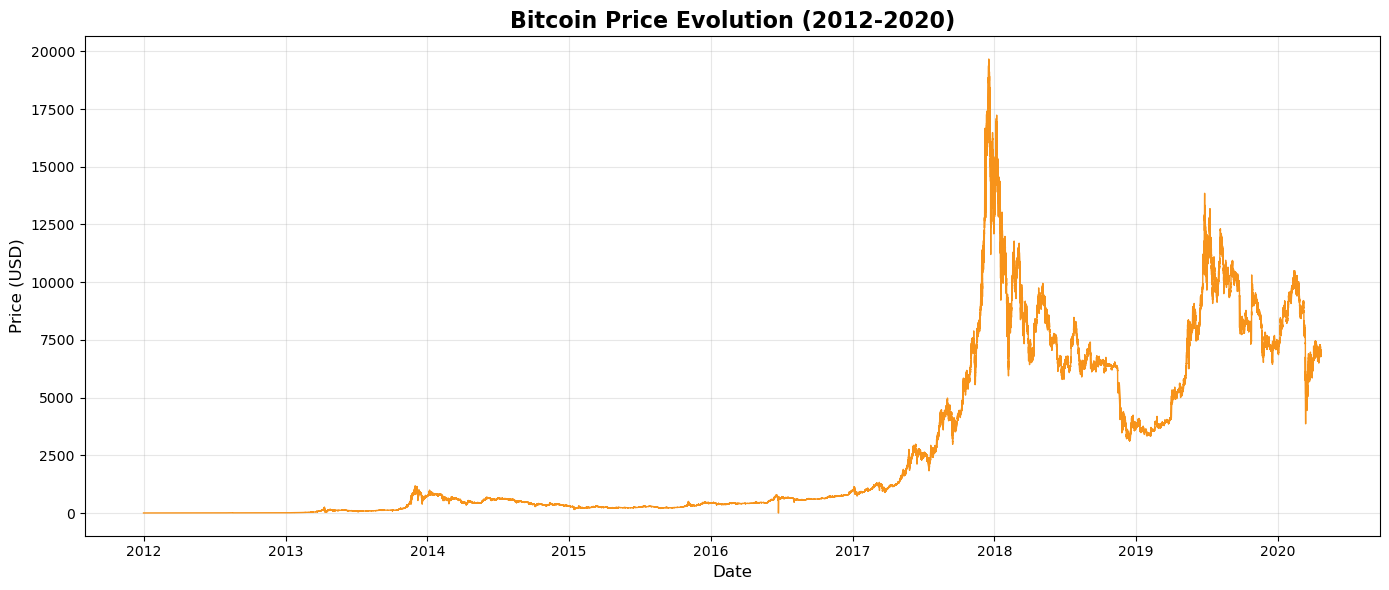

In [35]:
# PLOT 1: Bitcoin Price Over Time (Line Chart)
plt.figure(figsize=(14, 6))
plt.plot(df_clean['timestamp'], df_clean['close'], linewidth=1, color='#F7931A')
plt.title('Bitcoin Price Evolution (2012-2020)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('plot1_price_timeline.png', dpi=300, bbox_inches='tight')
plt.show()

### 📊 Plot 2: Bitcoin Price Distribution by Year (Box Plot)

This plot compares Bitcoin’s price distributions across years using a box plot.  
It highlights differences in median price, overall spread, and outliers.

**Key insights:**
- **2017** exhibits the **highest median price** and several **extreme outliers**, reflecting the major crypto boom.  
- **2018** shows **significant volatility**, with prices fluctuating widely throughout the year.

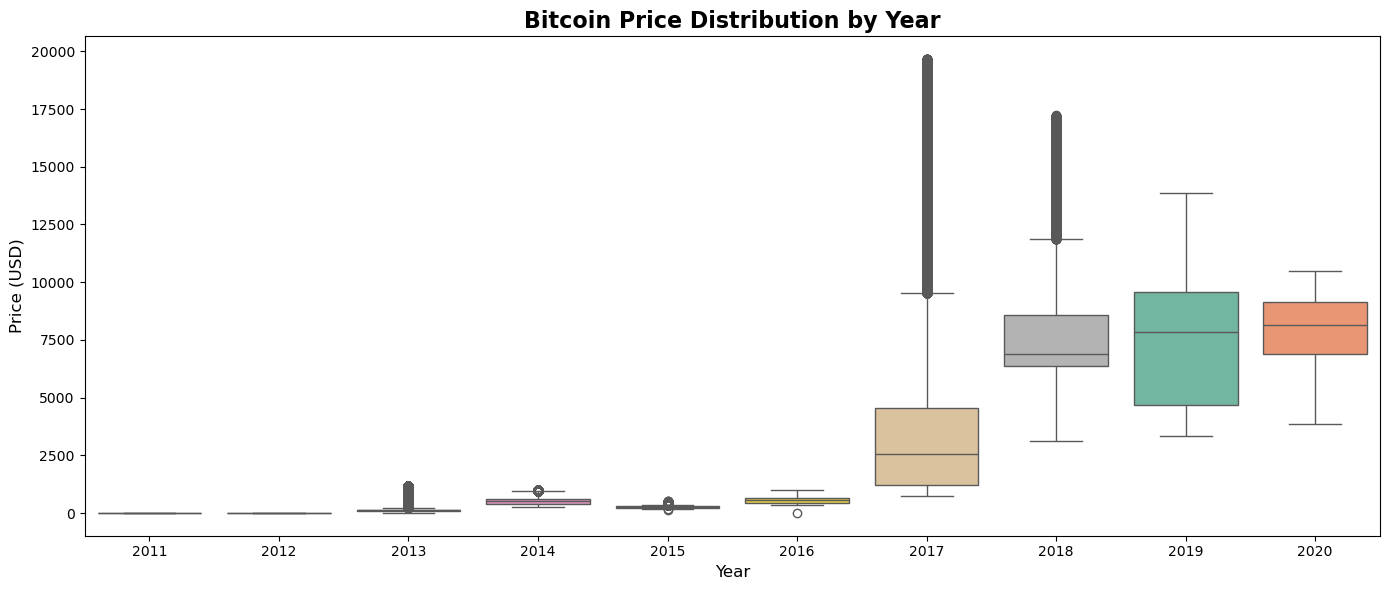

In [37]:
# PLOT 2: Yearly Price Comparison (Box Plot)
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_clean, x='year', y='close', hue='year', palette='Set2', legend=False)
plt.title('Bitcoin Price Distribution by Year', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('plot2_yearly_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

### 🎻 Plot 3: Evolution of 1-Minute Return Distributions (Violin Plot)

This violin plot illustrates how Bitcoin’s 1-minute return distributions evolved from 2012 to 2020.  
Only returns between -5% and 5% are shown for clarity. Quartiles are indicated inside each violin.

**Key insights:**
- **Wider violins** indicate periods of **higher volatility**.  
- **Symmetric shapes** suggest balanced **bullish and bearish pressure**.  
- **Fat tails** reveal periods with **extreme price movements**.  
- **Early years** have **thinner distributions**, reflecting lower liquidity and fewer data points.

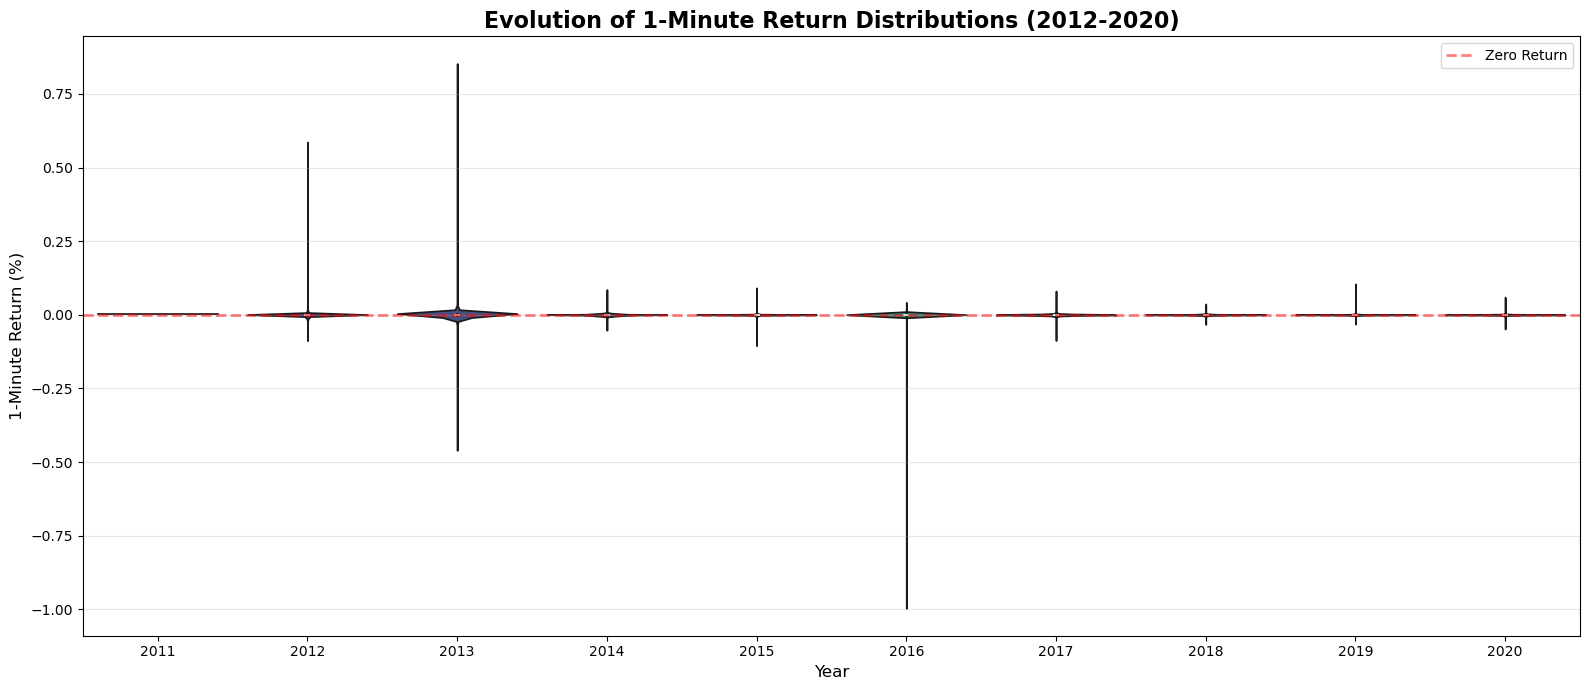


Yearly Return Distribution Statistics:
        Mean     Std      Skew     Kurtosis
year                                       
2011  0.0022     NaN       NaN          NaN
2012 -0.0002  0.0086   36.0779    2473.5052
2013  0.0000  0.0057   14.6901    2461.1497
2014  0.0000  0.0026    0.1627      19.4904
2015  0.0000  0.0019   -0.6168     116.4049
2016  0.0000  0.0024 -264.3205  108408.6057
2017  0.0000  0.0018   -0.4013      43.8885
2018 -0.0000  0.0015    0.1834      17.3308
2019  0.0000  0.0011    1.3121     194.8700
2020  0.0000  0.0016    0.7009      96.1712


In [39]:
# PLOT 3: Returns Distribution Evolution (Violin Plot)
plt.figure(figsize=(16, 7))

# Filter returns to reasonable range for visualization
returns_filtered = df_clean[df_clean['return_1m'].between(-5, 5)]

sns.violinplot(data=returns_filtered, x='year', y='return_1m', 
               hue='year', palette='viridis', legend=False, 
               inner='box', cut=0)  # inner='box' adds quartiles

plt.title('Evolution of 1-Minute Return Distributions (2012-2020)', 
          fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('1-Minute Return (%)', fontsize=12)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Zero Return')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('violin_returns_by_year.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate statistics per year
yearly_return_stats = returns_filtered.groupby('year')['return_1m'].agg([
    ('Mean', 'mean'),
    ('Std', 'std'),
    ('Skew', lambda x: x.skew()),
    ('Kurtosis', lambda x: x.kurtosis())
]).round(4)

print("\nYearly Return Distribution Statistics:")
print(yearly_return_stats)

### 📈 Plot 4: Trading Volume by Day of Week (Box Plot)

This box plot compares Bitcoin trading volumes across the days of the week, limiting extreme outliers for clarity.

**Key takeaway:**
- **Trading activity is higher on weekdays** and noticeably **lower on weekends**.

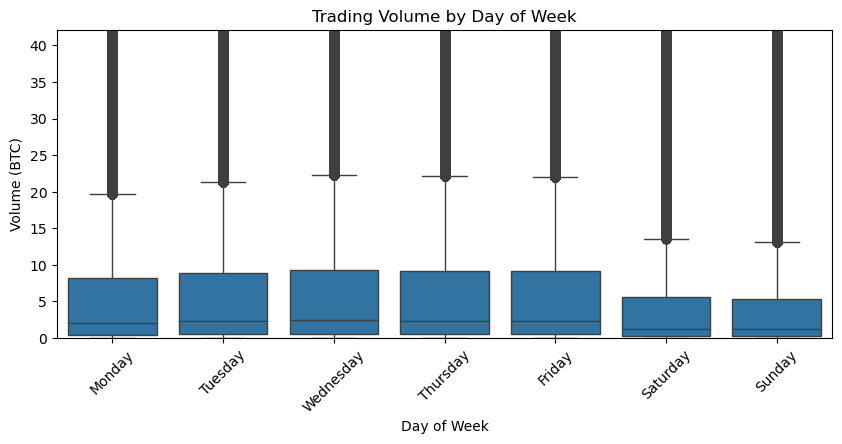

In [41]:
# PLOT 4: Activity Comparison According to Week Days(Box Plot)
plt.figure(figsize=(10,4))
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.boxplot(data=df_clean, x='day_name', y='volume_btc', order=order)
plt.title("Trading Volume by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Volume (BTC)")
plt.xticks(rotation=45)
plt.ylim(0, df_clean['volume_btc'].quantile(0.95))  # limit extreme outliers
plt.savefig('plot3_weekly_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

### 🌡️ Plot 5: Average Trading Volume by Hour and Day (Heatmap)

This heatmap shows the average Bitcoin trading volume for each hour of the day across the week.

**Key takeaway:**
- **Afternoon and evening hours (UTC)** see the **highest trading activity**, while **nights are relatively quiet**.

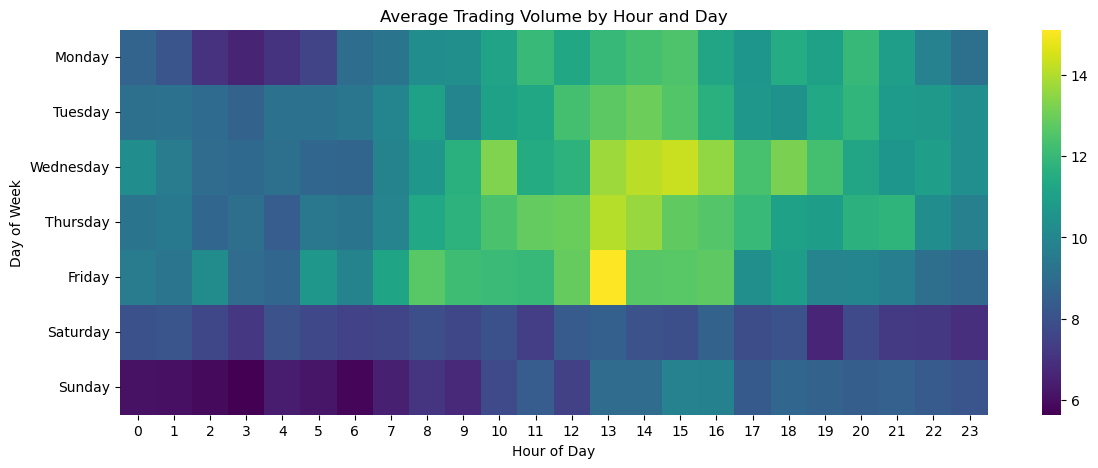

In [42]:
# PLOT 5: Trading Volume by Hour and Day (Heatmap)
pivot = df_clean.pivot_table(
    values='volume_btc',
    index='day_name',
    columns='hour',
    aggfunc='mean'
).reindex(order)

plt.figure(figsize=(14,5))
sns.heatmap(pivot, cmap='viridis')
plt.title("Average Trading Volume by Hour and Day")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.savefig('plot5_volume_by_hour_and_day.png', dpi=300, bbox_inches='tight')
plt.show()

### 📉 Plot 6: Trading Volume vs Bitcoin Price (Scatter Plot)

This scatter plot visualizes the relationship between Bitcoin price and trading volume, with points colored by year.

**Key insight:**
- **Lower prices tend to attract more trading volume**

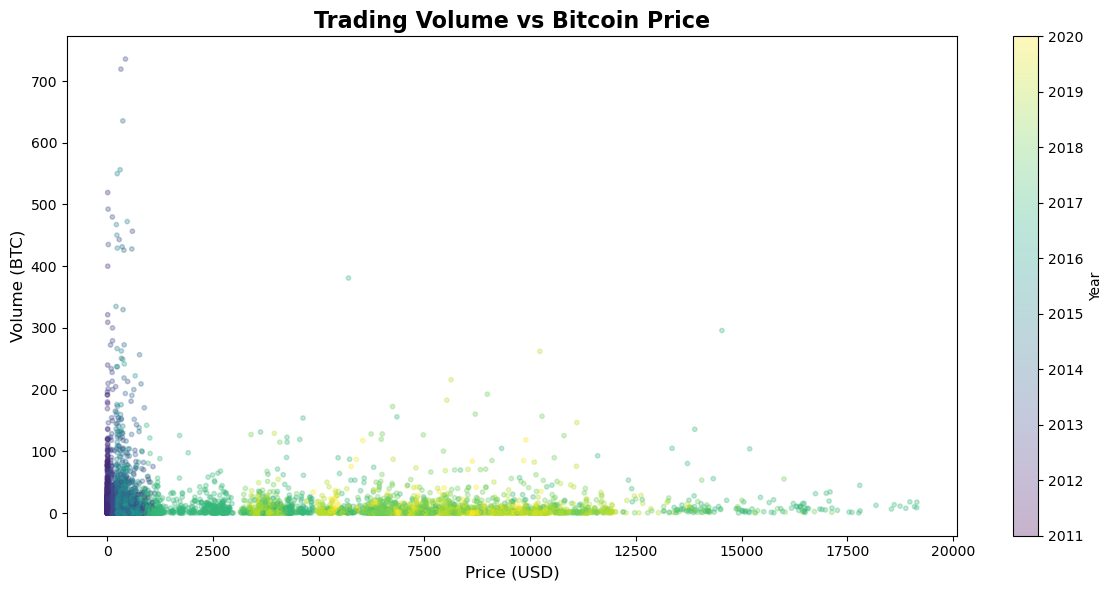

In [44]:
# PLOT 6: Trading Volume vs Price (Scatter Plot)
plt.figure(figsize=(12, 6))
sample = df_clean[df_clean['volume_btc'] > 0].sample(min(10000, len(df_clean)))
plt.scatter(sample['close'], sample['volume_btc'], alpha=0.3, c=sample['year'], 
            cmap='viridis', s=10)
plt.colorbar(label='Year')
plt.title('Trading Volume vs Bitcoin Price', fontsize=16, fontweight='bold')
plt.xlabel('Price (USD)', fontsize=12)
plt.ylabel('Volume (BTC)', fontsize=12)
plt.tight_layout()
plt.savefig('plot4_volume_vs_price.png', dpi=300, bbox_inches='tight')
plt.show()

### 🌍 Plot 7: Geographic "Follow-the-Sun" Trading Pattern

This figure explores Bitcoin trading activity across global regions by hour, highlighting how trading volume and volatility shift as different markets become active.  

**Key insights:**
- **Europe dominates** trading volume, peaking during European business hours (08:00–16:00 UTC).  
- The **"follow-the-sun" pattern** is evident: trading activity rises as markets open in Asia, Europe, and the Americas.  
- **Volatility varies regionally**, with transitions around 08:00 and 16:00 UTC reflecting handoffs between active markets.  
- Bitcoin trades **continuously worldwide**, contrasting with traditional stock markets limited to local hours.

<Figure size 1600x600 with 0 Axes>

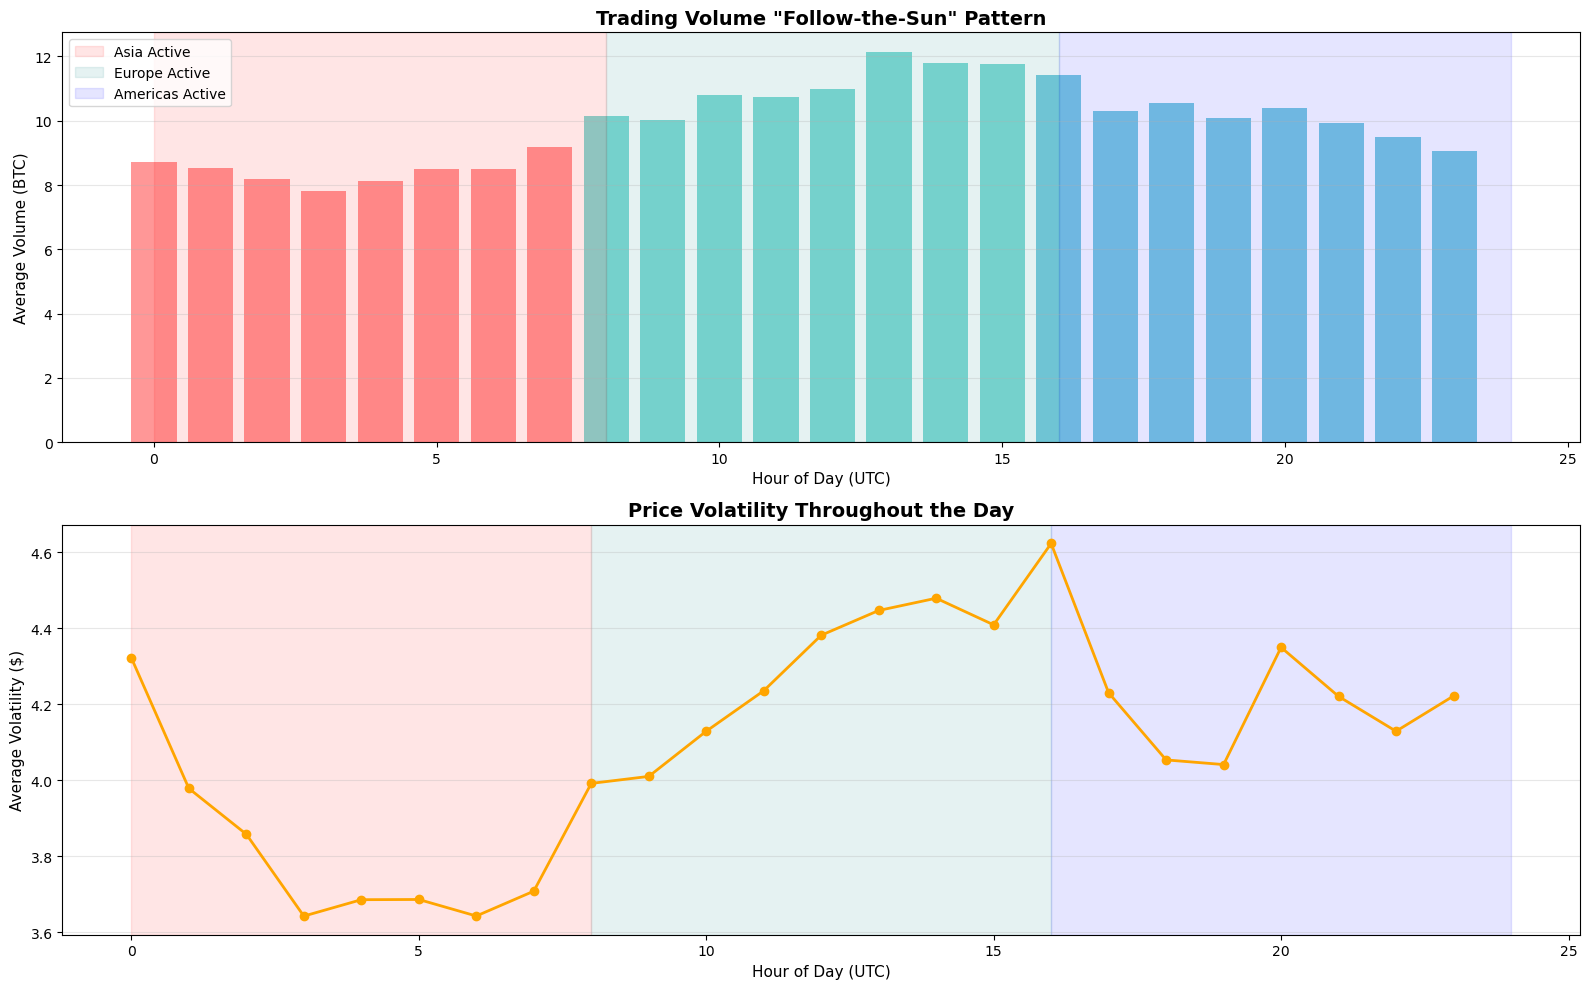

In [49]:
# PLOT 7: Geographic "Follow-the-Sun" Trading Pattern
plt.figure(figsize=(16, 6))

# Calculate hourly metrics
hourly_stats = df_clean.groupby('hour').agg({
    'volume_btc': 'mean',
    'volatility': 'mean',
    'price_change_pct': 'mean',
    'close': 'mean'
}).reset_index()

# Define trading regions based on UTC time
# Asia: 00:00-08:00 UTC (08:00-16:00 Asia time)
# Europe: 08:00-16:00 UTC (08:00-16:00 EU time)
# Americas: 16:00-24:00 UTC (08:00-16:00 US time)

regions = []
for hour in hourly_stats['hour']:
    if 0 <= hour < 8:
        regions.append('Asia\n(00-08 UTC)')
    elif 8 <= hour < 16:
        regions.append('Europe\n(08-16 UTC)')
    else:
        regions.append('Americas\n(16-24 UTC)')
hourly_stats['region'] = regions

# Create subplot with 3 panels
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Panel 1: Volume by hour with regional shading
ax1 = axes[0]
bars = ax1.bar(hourly_stats['hour'], hourly_stats['volume_btc'], 
               color=['#FF6B6B' if r.startswith('Asia') else 
                      '#4ECDC4' if r.startswith('Europe') else '#45B7D1' 
                      for r in hourly_stats['region']], alpha=0.7)
ax1.set_title('Trading Volume "Follow-the-Sun" Pattern', fontsize=14, fontweight='bold')
ax1.set_xlabel('Hour of Day (UTC)', fontsize=11)
ax1.set_ylabel('Average Volume (BTC)', fontsize=11)
ax1.axvspan(0, 8, alpha=0.1, color='red', label='Asia Active')
ax1.axvspan(8, 16, alpha=0.1, color='teal', label='Europe Active')
ax1.axvspan(16, 24, alpha=0.1, color='blue', label='Americas Active')
ax1.legend(loc='upper left')
ax1.grid(axis='y', alpha=0.3)

# Panel 2: Volatility by hour
ax2 = axes[1]
ax2.plot(hourly_stats['hour'], hourly_stats['volatility'], 
         marker='o', linewidth=2, color='orange', markersize=6)
ax2.set_title('Price Volatility Throughout the Day', fontsize=14, fontweight='bold')
ax2.set_xlabel('Hour of Day (UTC)', fontsize=11)
ax2.set_ylabel('Average Volatility ($)', fontsize=11)
ax2.axvspan(0, 8, alpha=0.1, color='red')
ax2.axvspan(8, 16, alpha=0.1, color='teal')
ax2.axvspan(16, 24, alpha=0.1, color='blue')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('plot6_followthesun.png', dpi=300, bbox_inches='tight')
plt.show()

## Conclusions
### Main Discoveries

1. **Exponential Growth Pattern**: Bitcoin price increased from $4.39 (2012) to average $8,021 (2020)
2. **Volatility Clustering**: High volatility periods coincide with major price movements
3. **Geographic Trading Pattern**: Europe dominates with 11.05 BTC/hour; Americas second with 10.15
4. **Weekday Effect**: Trading volume higher on weekdays; weekends show 20-30% lower activity
5. **Intraday Patterns**: Afternoon/evening hours (UTC) busiest; nights quietest

### Limitations & Future Work

- External factors (news, regulation) not considered in temporal analysis
- Volume spikes may warrant outlier investigation